In [1]:
try:
    from openmdao.utils.notebook_utils import notebook_mode  # noqa: F401
except ImportError:
    !python -m pip install openmdao[notebooks]

<script type="text/x-mathjax-config">
  MathJax.Hub.Config({
    TeX: {
      equationNumbers: {
        autoNumber: "AMS",
        useLabelIds: true
      }
    },
    displayAlign: "center"
  });
</script>

# Post-Optimality Sensitivities

Post-optimality sensitivities refer to the derivative of an optimization output wrt an optimization input.
These sensitivities are intended to inform the user of the cost of a design choice.
**These sensitivities only apply in the context of gradient-based optimization.**

## Viewing optimization as a nonlinear solve

From a MAUD perspective, one could view a gradient-based optimization as a nonlinear solve.

The implicit outputs in this context are the design varaible values, and the residual
equations come from the Karush-Kuhn-Tucker conditions for optimization.

### The Unconstrained Case

Consider the optimization of some function. Here is the standard form of the OpenMDAO 
paraboloid where we've replaced the constants with some parameters $p_0$, $p_1$, and $p_2$.

\begin{align}
\min_{x,\, y} \quad 
    & f(x, y; \mathbf{p}) = (x - p_0)^2 + x y + (y + p_1)^2 - p_2 \\
    \text{where} \quad 
    & \mathbf{p} = \begin{bmatrix} 3 \\ 4 \\ 3 \end{bmatrix} \in \mathbb{R}^3 \\
    & x, y \in \mathbb{R}
\end{align}

This system has 3 outputs ($f$, $x$, $y$) and 3 inputs ($\bar{p}$). So we may be interested in
in how those outputs change at the next converged solution subject to small changes in $\bar{p}$.

\begin{align}
    \frac{d x^*}{d \bar{p}} \\
    \frac{d y^*}{d \bar{p}} \\
    \frac{d f^*}{d \bar{p}} \\
\end{align}

In an unconstrained problem, the optimizer is finding the "bottom" of a multidimensional bowl:

\begin{align*}
  \mathcal{R_{KKT}}(\bar\theta, \bar{p}) = \nabla_\theta f(\bar{\theta}, \bar{p}) + \cancel{\lambda \nabla_\theta g(\bar{\theta}, \bar{p})} &= \bar{0}
\end{align*}

Where $\theta$ here represents the design variables instead of the typical $x$ in order to not confuse it with
the inputs the to the paraboloid above.
With two design variables, the residual vector $\mathcal{R_{KKT}}$ has two elements.

Our residual system has the following structure.

\begin{align*}
  \begin{bmatrix}
      \frac{df^*}{d\bar{p}} \\
  \end{bmatrix}
  &=
  \begin{bmatrix}
      \frac{df}{d\bar{p}} \\
  \end{bmatrix}
  -
  \cancel{
    \begin{bmatrix}
      \frac{df}{d\bar{\theta}} \\
    \end{bmatrix}
  }
  \begin{bmatrix}
     \frac{d \mathcal{R}_{KKT}}{d\bar{\theta}}  \\
  \end{bmatrix}^{-1}
  \begin{bmatrix}
      \frac{d \mathcal{R}_{KKT}}{d\bar{p}} \\
  \end{bmatrix}
\end{align*}

or, expanding terms...

\begin{align*}
  \begin{bmatrix}
      \frac{df^*}{dp_0} & \frac{df^*}{dp_1} & \frac{df^*}{dp_2} \\
  \end{bmatrix}
  &=
  \begin{bmatrix}
      \frac{df}{dp_0} & \frac{df}{dp_1} & \frac{df}{dp_2} \\
  \end{bmatrix}
  -
  \cancel{
    \begin{bmatrix}
      \frac{df}{dx} & \frac{df}{dy} \\
    \end{bmatrix}
  }
  \begin{bmatrix}
      \frac{d\nabla_x f}{dx} & \frac{d\nabla_x f}{dy} \\
      \frac{d\nabla_y f}{dx} & \frac{d\nabla_y f}{dy} \\
  \end{bmatrix}^{-1}
  \begin{bmatrix}
      \frac{d\nabla_x f}{dp_0} & \frac{d\nabla_x f}{dp_1} & \frac{d\nabla_x f}{dp_2} \\
      \frac{d\nabla_y f}{dp_0} & \frac{d\nabla_y f}{dp_1} & \frac{d\nabla_y f}{dp_2} \\
  \end{bmatrix}
\end{align*}

In an unconstrained optimization such as this, the gradient $\left[\frac{df}{d\bar{\theta}}\right]$ is zero, so the post-optimality sensitivity of the objective wrt the parameters is identical to the total derivative of the objective wrt the parameters.

The following code generates plots that sweep the value of each parameter and plot the resulting objective value, overlaid by vectors indicating the calculated derivative $\frac{df^*}{dp_i}$.

[GRLAL0222090115:22728] shmem: mmap: an error occurred while determining whether or not /var/folders/zm/r34jq9lj0sx2qdt4pj65sfd00000gp/T//ompi.GRLAL0222090115.502/jf.0/863830016/sm_segment.GRLAL0222090115.502.337d0000.0 could be created.


Nominal Solution:
   f*: [-27.33333333]
   x*: [6.66666667]
   y*: [-7.33333333]
   df*/dp0: [[-7.33333333]]
   df*/dp1: [[-6.66666667]]
   df*/dp2: [[-1.]]


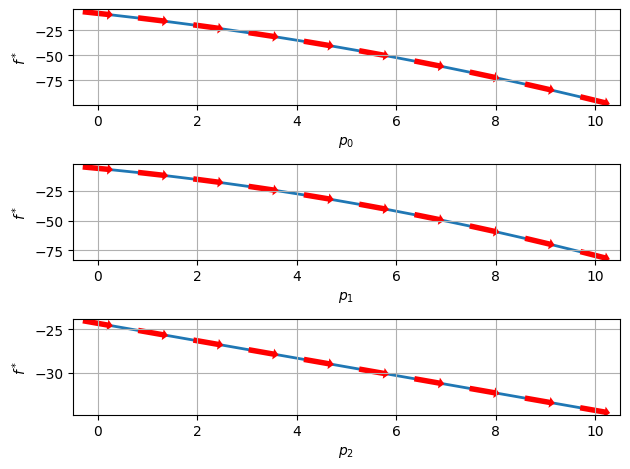

In [2]:
import numpy as np
import openmdao.api as om
import matplotlib.pyplot as plt

prob = om.Problem()
prob.model.add_subsystem('parab', om.ExecComp('f_xy = (x-p0)**2 + x*y + (y+p1)**2 - p2'),
                            promotes_inputs=['x', 'y', 'p0', 'p1', 'p2'],
                            promotes_outputs=['f_xy'])

# Design variables 'x' and 'y' span components, so we need to provide a common initial
# value for them.
prob.model.set_input_defaults('x', 3.0)
prob.model.set_input_defaults('y', -4.0)
prob.model.set_input_defaults('p0', 3.0)
prob.model.set_input_defaults('p1', 4.0)
prob.model.set_input_defaults('p2', 3.0)

# setup the optimization
prob.driver = om.pyOptSparseDriver()
prob.driver.options['print_results'] = False
prob.driver.options['optimizer'] = 'SLSQP'
prob.driver.options['singular_jac_behavior'] = 'ignore'

prob.model.add_design_var('x', lower=-50, upper=50)
prob.model.add_design_var('y', lower=-50, upper=50)
prob.model.add_objective('f_xy')

prob.setup()

prob.run_model()
driver_vars = prob.list_driver_vars(out_stream=None)
des_vars = [dv for dv, _ in driver_vars['design_vars']]
constraints = [dv for dv, _ in driver_vars['constraints']]
objs = [dv for dv, _ in driver_vars['objectives']]
other_ofs = []
other_wrts = ['p0', 'p1', 'p2']

ofs = objs + constraints + other_ofs
wrts = des_vars + other_wrts

fig, axs = plt.subplots(3, 1)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
ax1 = axs[0]
ax2 = axs[1]
ax3 = axs[2]

n_pts = 10
ps = np.linspace(0, 10, n_pts)
f_stars = np.zeros(n_pts)
df_stars_dps = np.zeros((3, n_pts))

prob.run_driver()
# No constraints, no lagrange multipliers
totals = prob.compute_totals(of=ofs, wrt=wrts, driver_scaling=False)

print('Nominal Solution:')
print('   f*:', prob.get_val('f_xy'))
print('   x*:', prob.get_val('x'))
print('   y*:', prob.get_val('y'))
print('   df*/dp0:', totals['f_xy', 'p0'])
print('   df*/dp1:', totals['f_xy', 'p1'])
print('   df*/dp2:', totals['f_xy', 'p2'])


for j in range(3):

    prob.set_val('p0', 3)
    prob.set_val('p1', 4)
    prob.set_val('p2', 3)

    for i, p in enumerate(ps):
        prob[f'p{j}'] = p
        prob.run_driver()
        f_stars[i] = np.copy(prob['f_xy'])[0]

        # est_multipliers, _ = prob.driver._get_lagrange_multipliers(driver_scaling=False, feas_tol=1.0E-6)

        totals = prob.compute_totals(of=ofs, wrt=wrts, driver_scaling=False)

        # dfstar_dg = est_multipliers['g']
        # dg_dp = totals['g', 'p0']
        dfstar_dpj= totals['f_xy', f'p{j}']

        # df_stars_dps[i] = np.copy(est_multipliers['g'] * (prob['x'] + prob['y']))
        df_stars_dps[j, i] = np.copy(dfstar_dpj).ravel()[0]



    uv = np.column_stack([np.ones_like(df_stars_dps[j]),
                            df_stars_dps[j]])

    uv_norm = np.linalg.norm(uv, axis=1)
    uv /= uv_norm[:, np.newaxis]

    axs[j].plot(ps,
                f_stars,
                zorder=0,
                linewidth=2.0)
    axs[j].quiver(ps,
                f_stars,
                uv[:,0],
                uv[:,1],
                angles="xy",
                pivot="mid",
                color="red",
                width=0.01,
                headwidth=2,
                headlength=1.0,
                headaxislength=1.0,
                minshaft=0.1,
                minlength=0.5)

    axs[j].set(xlabel=f'$p_{j}$', ylabel=r'$f^*$')
    axs[j].grid()

fig.tight_layout()

plt.show()

## Optimal design variable sensitivities for unconstrained optimization

In the section above, we demonstrate the ability to get the post-optimality sensitivity of the objective with respect to some parameters of the problem.

Now we want to know, how would the optimal values of $x$ and $y$ change as the values of $\bar{p}$ are changed?
The KKT residual is still the same for the unconstrained case.
Viewing the problem as an implicit solve, we have the following linear system for the residuals

\begin{align*}
  \begin{bmatrix}
      \frac{d{\bar{\theta}}^*}{d\bar{p}} \\
  \end{bmatrix}
  &=
  \cancel{
    \begin{bmatrix}
      \frac{d{\bar{\theta}}}{d{\bar{p}}} \\
    \end{bmatrix}
  }
  -
  \begin{bmatrix}
      \frac{d{\bar{\theta}}}{d{\bar{\theta}}} \\
  \end{bmatrix}
  \begin{bmatrix}
    \frac{d\mathcal{R}_{KKT}}{d{\bar{\theta}}} \\
  \end{bmatrix}^{-1}
  \begin{bmatrix}
      \frac{d\mathcal{R}_{KKT}}{d\bar{p}} \\
  \end{bmatrix}
\end{align*}

The term $\frac{d{\bar{\theta}}}{d{\bar{p}}}$ drops to zero because the unoptimized design variables are not impacted by the choice of the parameters.
The term $\frac{d{\bar{\theta}}}{d{\bar{\theta}}}$ is just an identity matrix, so we're left with:

\begin{align*}
  \begin{bmatrix}
      \frac{d{\bar{\bar{\theta}}}^*}{d\bar{p}} \\
  \end{bmatrix}
  &=
  -
  \begin{bmatrix}
    \frac{d\nabla_{\bar{\theta}} {f}}{d{\bar{\theta}}} \\
  \end{bmatrix}^{-1}
  \begin{bmatrix}
      \frac{d\nabla_{\bar{\theta}} {f}}{d\bar{p}} \\
  \end{bmatrix}
\end{align*}

or equivalently

\begin{align*}
  \begin{bmatrix}
    \frac{d\nabla_{\bar{\theta}} {f}}{d{\bar{\theta}}} \\
  \end{bmatrix}
  \begin{bmatrix}
      \frac{d{\bar{\theta}}^*}{d\bar{p}} \\
  \end{bmatrix}
  &=
  -
  \begin{bmatrix}
      \frac{d\nabla_{\bar{\theta}} {f}}{d\bar{p}} \\
  \end{bmatrix}
\end{align*}

So given $\frac{d\nabla_{\bar{\theta}} {f}}{d{\bar{\theta}}}$ and $\frac{d\nabla_{\bar{\theta}} {f}}{d\bar{p}}$, a linear solve provides the sensitivities $\frac{d{\bar{\theta}}^*}{d\bar{p}}$.

But how do we obtain these?

A derivative of a gradient is a second derivative, and OpenMDAO currently does not provide second derivatives.

### Using the Lagrange Multipliers

In a constrained optimization problem, Lagrange multiplier terms are included in the KKT residual for each active constraint.
The presence of active constraints means that the optimization will not find the "bottom of the bowl", but rather be limited to finding some minimal value on the surface of the bowl where the active constraint residual is zero.

\begin{align*}
  \mathcal{R_{KKT}} =
  \begin{bmatrix}
  \nabla_{\bar{\theta}} f + \nabla_{\bar{\theta}} \bar{g}^T \bar\lambda + \nabla_{\bar{\theta}} \bar{h}^T_\mathcal{A} \bar\mu_\mathcal{A} + \bar\nu_\mathcal{A}
  \end{bmatrix} &= \bar{0}
\end{align*}

Where $\bar{g}$ are the equality constraints, $\bar{h}_\mathcal{A}$ are the active inequality constraints.

Lumping all active constraints and bounds into a single pseudo-equality-constraint vector $\mathcal{G}$, we have

\begin{align*}
  \nabla_{\bar{\theta}} \mathcal{G}^T \begin{bmatrix}\bar\lambda \\ \bar\mu \\ \bar\nu \end{bmatrix} = -\nabla_{\bar{\theta}} f
\end{align*}

For the sake of simplicity we're just going to use $\bar\lambda$ to encompass Lagrange multipliers for all active constraints from here on:

\begin{align*}
  \left[ \nabla_{\bar{\theta}} \mathcal{G}^T \right] \bar\lambda = - \left[ \nabla_{\bar{\theta}} f \right]
\end{align*}

The gradients in the above equation are obtained by a call to OpenMDAO's `problem.compute_totals` method.

From this we can find the multipliers using a least squares method in order to allow a little slack due to numerical issues.
These multipliers give the _post-optimality sensitivities_ of the objective $f$ with respect to the active constraint bound values for the equality constraints, inequality constraints, and design variables, respectively.

Now suppose, having already found the optimal solution that satisfies the KKT conditions, we treat the design variable vector $\bar\theta$ as if it were equality-constrained to those optimal values:

\begin{align*}
  \mathcal{G} = \begin{bmatrix}x - x* \\ y - y* \end{bmatrix} &= \left[ 0 \right]
\end{align*}

Since OpenMDAO doesn't provide second derivative information at this time, we rely on finite-difference for this step.
If we were to perturb the design variables $x$ and $y$ away from their optimal values and solve the KKT system, the resulting multpliers would approximate the sensitivities of the objective with respect to the design variables constrained to their optimal values, $\frac{d f^*}{d{{\bar{\theta}}}}$.

\begin{align}
    \frac{d^2 f^*}{d\bar{\theta}^2} &\approx \frac{-\bar{\lambda}(\bar{\theta^*} + \Delta h, \bar{p}) - (-\bar{\lambda}(\bar{\theta^*}, \bar{p}))}{\Delta h}
\end{align}

Similarly, a perturbation of the parameter values and treating them as if they were constraints would give us $\frac{d\nabla_{{\bar{\theta}}} {f}}{d{\bar{p}}}$.

\begin{align}
    \frac{d^2 f^*}{d\bar{\theta}d\bar{p}} &\approx \frac{-\bar{\lambda}(\theta^*, \bar{p} + \Delta h) - (-\bar{\lambda}(\theta^*, \bar{p}))}{\Delta h}
\end{align}


In [3]:
import numpy as np
import openmdao.api as om
import matplotlib.pyplot as plt

prob = om.Problem()
prob.model.add_subsystem('parab', om.ExecComp('f = (x-p0)**2 + x*y + (y+p1)**2 - p2'),
                            promotes_inputs=['x', 'y', 'p0', 'p1', 'p2'],
                            promotes_outputs=['f'])

# Design variables 'x' and 'y' span components, so we need to provide a common initial
# value for them.
prob.model.set_input_defaults('x', 3.0)
prob.model.set_input_defaults('y', -4.0)
prob.model.set_input_defaults('p0', 3.0)
prob.model.set_input_defaults('p1', 4.0)
prob.model.set_input_defaults('p2', 3.0)

# setup the optimization
prob.driver = om.pyOptSparseDriver()
prob.driver.options['print_results'] = False
prob.driver.options['optimizer'] = 'SLSQP'
prob.driver.options['singular_jac_behavior'] = 'ignore'

prob.model.add_design_var('x', lower=-50, upper=50)
prob.model.add_design_var('y', lower=-50, upper=50)
prob.model.add_objective('f')

prob.setup()

PERTURB_H = 1.0E-7

p0 = 3.
p1 = 4.
p2 = 3.
prob.set_val('p0', p0)
prob.set_val('p1', p1)
prob.set_val('p2', p2)

prob.run_driver()

fstar = np.copy(prob.get_val('f'))
xstar = np.copy(prob.get_val('x'))
ystar = np.copy(prob.get_val('y'))

# # NOTE: We get the wrong answers if we don't use np.copy here.
# fstar = prob.get_val('f')
# xstar = prob.get_val('x')
# ystar = prob.get_val('y')

print('f*', fstar)
print('x*', xstar)
print('y*', ystar)

print()

sensitivity_matrix = prob.driver.compute_sensitivities(wrt=['p0', 'p1', 'p2'])



f* [-27.33333333]
x* [6.66666667]
y* [-7.33333333]



In [4]:
from bokeh.io import output_notebook

output_notebook()

p = om.view_sensitivities(prob, wrt=['p0', 'p1', 'p2'])

Loading BokehJS ...

## Vectorized Systems

Suppose both the design variables and the parameters contain vectors.
The same math holds, but we need to make sure that the coding accommodates vectorized data.

In [5]:
import numpy as np
import openmdao.api as om
import matplotlib.pyplot as plt

prob = om.Problem()
prob.model.add_subsystem('parab', om.ExecComp(['f = (theta[0] - p[0])**2 + theta[0] * theta[1] + (theta[1] + p[1])**2 - p[2]'],
                                               theta = {'shape': (2,),},
                                               p = {'shape': (3,)}))

prob.model.set_input_defaults('parab.theta', [3.0, -4.0])
prob.model.set_input_defaults('parab.p', [3.0, 4.0, 3.0])

# setup the optimization
prob.driver = om.pyOptSparseDriver()
prob.driver.options['print_results'] = False
prob.driver.options['optimizer'] = 'SLSQP'
prob.driver.options['singular_jac_behavior'] = 'ignore'

prob.model.add_design_var('parab.theta', lower=-50, upper=50)
prob.model.add_objective('parab.f')

prob.setup()

p0 = 3.
p1 = 4.
p2 = 3.
prob.set_val('parab.p', [p0, p1, p2])

prob.run_driver()

fstar = np.copy(prob.get_val('parab.f')[0])
xstar, ystar = np.copy(prob.get_val('parab.theta'))

print('f*', fstar)
print('x*', xstar)
print('y*', ystar)

sens_mat, rows, cols = prob.driver.compute_sensitivities(wrt=['parab.p'])
rows = ['f*', 'theta_0*', 'theta_1*']
print('\nSensitivities:')
with np.printoptions(formatter={'float': '{:16.8f}'.format}):
   print(f'           {"p_0":>17s}{"p_1":>17s}{"p_2":>17s}')
   for i in range(sens_mat.shape[0]):
      print(f'{rows[i]:>10s}', sens_mat[i, :])

f* -27.33333333333333
x* 6.666666666666667
y* -7.333333333333334

Sensitivities:
                         p_0              p_1              p_2
        f* [     -7.33333333      -6.66666667      -1.00000000]
  theta_0* [      1.33333341       0.66666672      -0.00000003]
  theta_1* [     -0.66666672      -1.33333339       0.00000005]


Lets test it out, changing `p[0]` by a 0.01 units and rerunning the optimization should decrease `f` by 0.73 units, increase `theta[0]` by 0.13 units, and decrease `theta[1]` by 0.06 units.

In [6]:
from openmdao.utils.assert_utils import assert_near_equal

delta_p0 = 0.1
prob.set_val('parab.p', [p0 + delta_p0, p1, p2])
prob.run_driver()

fstar1 = np.copy(prob.get_val('parab.f')[0])
xstar1, ystar1 = np.copy(prob.get_val('parab.theta'))

print('f*', fstar1)
print('x*', xstar1)
print('y*', ystar1)

print('\nChanges:')
print('f*', fstar1 - fstar)
print('x*', xstar1 - xstar)
print('y*', ystar1 - ystar)

assert_near_equal(fstar1 - fstar, delta_p0 * sens_mat[0, 0], tolerance=1.0E-2)
assert_near_equal(xstar1 - xstar, delta_p0 * sens_mat[1, 0], tolerance=1.0E-2)
assert_near_equal(ystar1 - ystar, delta_p0 * sens_mat[2, 0], tolerance=1.0E-2)

print('Success!')

f* -28.07
x* 6.8
y* -7.3999999999999995

Changes:
f* -0.7366666666666717
x* 0.13333333333333286
y* -0.06666666666666554
Success!


In [7]:
from bokeh.io import output_notebook
output_notebook()
prob.set_val('parab.p', [p0, p1, p2])
prob.run_driver()
om.view_sensitivities(prob, wrt=['parab.p'])

Loading BokehJS ...

figure(id='p1051', ...)

# The Constrained Case

Now lets consider an update to the problem such that we have an active bound and an active inequality constraint.

\begin{align*}
\min_{x,\, y} \quad & f(x, y; \mathbf{p}) = (x - p_0)^2 + x y + (y + p_1)^2 - p_2 \\
\text{where} \quad \mathbf{p} &= \begin{bmatrix} 3 \\ 4 \\ 3 \end{bmatrix} \in \mathbb{R}^3 \\
\text{bounds:} \quad x &\le 6 \\
\text{equality constraints:} \quad y &= -x
\end{align*}

If active, we can treat the bound on $x$ as just another equality constraint.

\begin{align*}
  \left[ \mathcal{G} \right] &= \begin{bmatrix}
                                   x + y \\
                                   x - x_{ub}
                                \end{bmatrix} = \left[ 0 \right]
\end{align*}

Then, if we want to know the sensitivity of the optimization to the value of $x_{ub}$, as if is another parameter to the problem, we can assume $x_{ub}$ is just another element in our parameter vector:

\begin{align*}
    \left[ \mathcal{P} \right] &= \begin{bmatrix} p_0 \\ p_1 \\ p_2 \\ -x_{ub} \end{bmatrix}
\end{align*}

\begin{align*}
  \left[ \nabla_{\mathcal{P}} \mathcal{G} \right] &= \begin{bmatrix} 0 & 0 & 0 & -1 \end{bmatrix}
\end{align*}

So we compute the sensitivities wrt to these parameters in exactly the same way, except that the sensitivity will have the sign opposite for the other parameters.

(-15.0, 0.0)

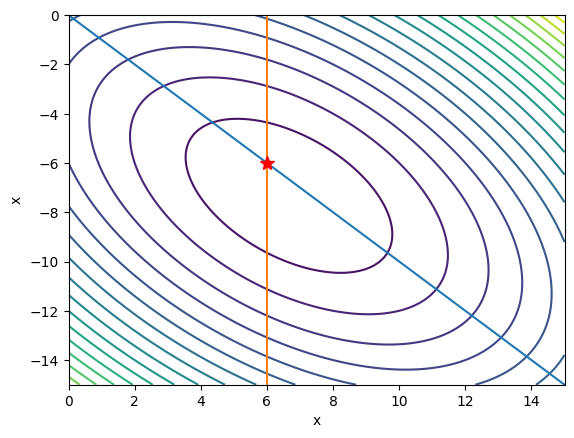

In [8]:
from matplotlib.cm import viridis

def f(x, y, p0, p1, p2):
    return (x - p0)**2 + x * y + (y + p1)**2 - p2

def g(x, y, p0, p1):
    return -x

x = np.linspace(0, 15, 100)
y = np.linspace(-15, 0, 100)

XX, YY = np.meshgrid(x, y)
ZZ = f(XX, YY, 3, 4, 3)

fig, ax = plt.subplots(1, 1)
ax.contour(XX, YY, ZZ, levels=20, cmap=viridis)

ax.plot(x, g(x, y, p0, p1))
ax.plot(6 * np.ones_like(y), y)
plt.plot([6], [-6], 'r*', ms=10)
ax.set_xlabel('x')
ax.set_ylabel('x')
ax.set_xlim(0, 15)
ax.set_ylim(-15, 0)

In [4]:
import numpy as np
import openmdao.api as om
import matplotlib.pyplot as plt

prob = om.Problem()
prob.model.add_subsystem('parab', om.ExecComp(['f = (theta[0] - p[0])**2 + theta[0] * theta[1] + (theta[1] + p[1])**2 - p[2]',
                                               'h = sum(theta)'],
                                               theta = {'shape': (2,),},
                                               p = {'shape': (3,)},
                                               h = {'shape': (1,)}))

prob.model.set_input_defaults('parab.theta', [3.0, -4.0])
prob.model.set_input_defaults('parab.p', [3.0, 4.0, 3.0])

# setup the optimization
prob.driver = om.pyOptSparseDriver()
prob.driver.options['print_results'] = False
prob.driver.options['optimizer'] = 'SNOPT'
prob.driver.options['singular_jac_behavior'] = 'ignore'

prob.model.add_design_var('parab.theta', lower=-50, upper=6)
# prob.model.add_constraint('parab.h', equals=0.0)
prob.model.add_objective('parab.f')

prob.setup()

p0 = 3.
p1 = 4.
p2 = 3.
prob.set_val('parab.p', [p0, p1, p2])

prob.run_driver()

fstar = np.copy(prob.get_val('parab.f')[0])
xstar, ystar = np.copy(prob.get_val('parab.theta'))

print('f*', fstar)
print('x*', xstar)
print('y*', ystar)

lam, actives = prob.driver._compute_lagrange_multipliers()

print(lam)


f* -27.0
x* 6.0
y* -7.0
{'parab.theta': array([1., 0.])}


/Users/rfalck/Codes/OpenMDAO.git/openmdao/utils/coloring.py:448: DerivativesWarning:'parab' <class ExecComp>: Coloring was deactivated.  Improvement of 0.0% was less than min allowed (5.0%).


The goal of sensitivity analysis is to produce the sensitivity (derivatives) of the outputs of the optimization with respect to the inputs.


The outputs of the optimization are:
- The optimal objective value $\left(f^* = f(\bar\theta^*, p)\right)$
- The optimal design variable values ($\bar\theta^*$)
- Other "auxiliary" outputs $\bar{y}^* = \left(\bar{y}(\bar\theta^*, \bar{p})\right)$.

\begin{align*}
  \bar{\mathcal{Y}} &= \begin{bmatrix} f^* \\ \bar{\theta}^* \\ \bar{y}^* \end{bmatrix}
\end{align*}

The inputs of the optimization are:
- Parameter inputs to the optimization $\left( \bar{p} \right)$
- The bounds on any design variables or constraints. $\left( \bar{\mathcal{G}}_{lb}, \bar{\mathcal{G}}_{eq}, \bar{\mathcal{G}}_{ub} \right)$


Where $\bar{\mathcal{G}}$ consists of bounds constraints that apply to the design variables, equality constraints, and inequality constraints.
When solving for the Lagrange multipliers, we consider only the active bounds ($_{ab}$)

\begin{align*}
  \bar{\mathcal{X}} &= \begin{bmatrix} \bar{p} \\ \bar{\mathcal{G}}_{ab} \end{bmatrix}
\end{align*}


The sensitivity matrix has the following block structure:

\begin{align*}
  \frac{d\bar{\mathcal{Y}}}{d\bar{\mathcal{X}}} &=
  \begin{bmatrix}
    \frac{df^*}{d\bar{p}} & \frac{df^*}{d\bar{\mathcal{G}}_{ab}} \\ 
    \\
    \frac{d\bar{\theta}^*}{d\bar{p}} & \frac{d\bar{\theta}^*}{d\bar{\mathcal{G}}_{ab}} \\
    \\
    \frac{d\bar{y}^*}{d\bar{p}} & \frac{d\bar{y}^*}{d\bar{\mathcal{G}}_{ab}}
  \end{bmatrix} 
\end{align*}


## Computing $\left[ \frac{df^*}{d\bar{p}} \right]$

The outputs of the optimization are the result of an implicit process, where the residuals solved are the stationarity condition (the gradient of the Lagrangian wrt the design variables is zero).

\begin{align*}
  \mathcal{R} =
  \nabla_{\bar{\theta}} \mathcal{L}(\bar\theta, \bar{p}) =
  \nabla_{\bar{\theta}} f(\bar\theta, \bar{p}) + \nabla_{\bar{\theta}} \bar{\mathcal{G}}^T (\bar\theta, \bar{p}) \bar\lambda 
  &= \bar{0}
\end{align*}

Here we're making the following assertions:
1. We know the active set, so we don't worry about residuals imposed by the other KKT conditions, like complementary slackness. We are essentially trusting the optimizer to satisfy the KKT conditions for us.
2. Infintesimal perturbations to the systems will not change the active set.

\begin{align*}
  \begin{bmatrix}
      \frac{df^*}{d\bar{p}} \\
  \end{bmatrix}
  &=
    \begin{bmatrix}
      \frac{d f}{d{\bar{p}}} \\
    \end{bmatrix}
  -
  \begin{bmatrix}
      \frac{df}{d{\bar{\theta}}} \\
  \end{bmatrix}
  \begin{bmatrix}
    \frac{d\mathcal{R}}{d{\bar{\theta}}} \\
  \end{bmatrix}^{-1}
  \begin{bmatrix}
      \frac{d\mathcal{R}}{d\bar{p}} \\
  \end{bmatrix}
\end{align*}

This is the sample implicit function theorem we always use, except the partial terms we'd normally see are replaced with derivatives of the non-optimal outputs.

The partials of the residual are second order terms computed as:

\begin{align*}
  \frac{d\mathcal{R}}{d{\bar{\theta}}} =
  \frac{d \nabla_{\bar{\theta}} \mathcal{L}(\bar\theta, \bar{p})}{d\bar{\theta}} =
  \frac{d \nabla_{\bar{\theta}} f(\bar\theta, \bar{p})}{d \bar{\theta}} +
  \frac{d \nabla_{\bar{\theta}} \bar{\mathcal{G}}^T (\bar\theta, \bar{p})}{d \bar{\theta}} \bar\lambda +
  \nabla_{\bar{\theta}} \bar{\mathcal{G}}^T (\bar\theta, \bar{p}) \frac{d \bar\lambda}{d \bar{\theta}}
  \\
  \frac{d\mathcal{R}}{d \bar{p}} =
  \frac{d \nabla_{\bar{\theta}} \mathcal{L}(\bar\theta, \bar{p})}{d \bar{p}} =
  \frac{d \nabla_{\bar{\theta}} f(\bar\theta, \bar{p})}{d \bar{p}} +
  \frac{d \nabla_{\bar{\theta}} \bar{\mathcal{G}}^T (\bar\theta, \bar{p})}{d \bar{p}} \bar\lambda +
  \nabla_{\bar{\theta}} \bar{\mathcal{G}}^T (\bar\theta, \bar{p}) \frac{d \bar\lambda}{d \bar{p}}
\end{align*}

OpenMDAO supports first derivatives, so we need to obtain finite difference approximations of the second order terms.

Now having computed all elements on the right hand side, we can compute this in direct mode if there are fewer parameters and active constraints than outputs of interest:

\begin{align*}

  \begin{bmatrix}
      \frac{d\mathcal{R}}{d\bar{p}} \\
  \end{bmatrix}
  &=
  \begin{bmatrix}
    \frac{d\mathcal{R}}{d{\bar{\theta}}} \\
  \end{bmatrix}
  \bar{\phi}
\end{align*}

\begin{align*}
  \begin{bmatrix}
      \frac{df^*}{d\bar{p}} \\
  \end{bmatrix}
  &=
    \begin{bmatrix}
      \frac{d f}{d{\bar{p}}} \\
    \end{bmatrix}
  -
  \begin{bmatrix}
      \frac{df}{d{\bar{\theta}}} \\
  \end{bmatrix}
  \bar{\phi}
\end{align*}



Or if we have fewer outputs of interest than parameters and active constraints we solve it in adjoint mode:

\begin{align*}
  \begin{bmatrix}
    \frac{d\mathcal{R}}{d{\bar{\theta}}} \\
  \end{bmatrix}^T \bar{\psi} =   \begin{bmatrix}
      \frac{df}{d{\bar{\theta}}} \\
  \end{bmatrix}^T
\end{align*}

\begin{align*}
  \begin{bmatrix}
      \frac{df^*}{d\bar{p}} \\
  \end{bmatrix}
  &=
    \begin{bmatrix}
      \frac{d f}{d{\bar{p}}} \\
    \end{bmatrix}
  -
  \bar{\psi}
  \begin{bmatrix}
      \frac{d\mathcal{R}}{d\bar{p}} \\
  \end{bmatrix}
\end{align*}

## Compute $\left[ \frac{df^*}{d\bar{\mathcal{G}}_{ab}} \right]$

By definition, the Lagrange multipliers are the sensitivity of the objective function with respect to each active constraint or bound.

Recall that we defined them as:

\begin{align*}
  \mathcal{R} =
  \nabla_{\bar{\theta}} \mathcal{L}(\bar\theta, \bar{p}) =
  \nabla_{\bar{\theta}} f(\bar\theta, \bar{p}) + \nabla_{\bar{\theta}} \bar{\mathcal{G}}^T (\bar\theta, \bar{p}) \bar\lambda 
  &= \bar{0}
\end{align*}

so

\begin{align*}
  -\nabla_{\bar{\theta}} f(\bar\theta, \bar{p}) = \nabla_{\bar{\theta}} \bar{\mathcal{G}}^T (\bar\theta, \bar{p}) \bar\lambda 
\end{align*}

thus

\begin{align*}
\left[ \frac{df^*}{d\bar{\mathcal{G}}_{ab}} \right] &= -\bar{\lambda}
\end{align*}

## Computing $\left[ \frac{d \bar{\theta}^*}{d\bar{p}} \right]$

Similar to the sensitivities of the optimal design variable values, we have:

\begin{align*}
  \begin{bmatrix}
      \frac{d{\bar{\theta}}^*}{d\bar{p}} \\
  \end{bmatrix}
  &=
    \begin{bmatrix}
      \frac{d {\bar{\theta}}}{d{\bar{p}}} \\
    \end{bmatrix}
  -
  \begin{bmatrix}
      \frac{d{\bar{\theta}}}{d{\bar{\theta}}} \\
  \end{bmatrix}
  \begin{bmatrix}
    \frac{d\mathcal{R}}{d{\bar{\theta}}} \\
  \end{bmatrix}^{-1}
  \begin{bmatrix}
      \frac{d\mathcal{R}}{d\bar{p}} \\
  \end{bmatrix}
\end{align*}

But the "partials" of design variable values with respect to the parameters are zero, so $\left[  \frac{d {\bar{\theta}}}{d{\bar{p}}} \right]$ drops to zero.

Furthermore, $\left[ \frac{d{\bar{\theta}}}{d{\bar{\theta}}} \right]$ is just identity, so we have:

\begin{align*}
  \begin{bmatrix}
      \frac{d{\bar{\theta}}^*}{d\bar{p}} \\
  \end{bmatrix}
  &=
  -
  \begin{bmatrix}
    \frac{d\mathcal{R}}{d{\bar{\theta}}} \\
  \end{bmatrix}^{-1}
  \begin{bmatrix}
      \frac{d\mathcal{R}}{d\bar{p}} \\
  \end{bmatrix}
  &= - \bar{\phi}
\end{align*}

This is the same $\bar{\phi}$ used in the direct approach to compute the sensitivities of the objective wrt to the active constraints.


## Compute $\left[ \frac{d\bar{\theta}^*}{d\bar{\mathcal{G}}_{ab}} \right]$

It may help to think of each constraint bound as another type of parameter, we'll call $\bar{p}_g$.

Where we would typically define an active constraint as

\begin{align*}
    g(\bar\theta, \bar{p}) = \bar{p}_g
\end{align*}

or

\begin{align*}
    \bar{\mathcal{R}}_g &= \bar{g}(\bar\theta, \bar{p}) - \bar{p}_g &= \bar{0}
\end{align*}

So as before

\begin{align*}
  \begin{bmatrix}
      \frac{d{\bar{\theta}}^*}{d\bar{p}_g} \\
  \end{bmatrix}
  &=
  -
  \begin{bmatrix}
    \frac{d\mathcal{R}}{d{\bar{\theta}}} \\
  \end{bmatrix}^{-1}
  \begin{bmatrix}
      \frac{d\mathcal{R}}{d\bar{p}_g} \\
  \end{bmatrix}
\end{align*}